## Import Libraries

In [2]:
# inbuilt libraries
import cv2
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# external libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data Analysis

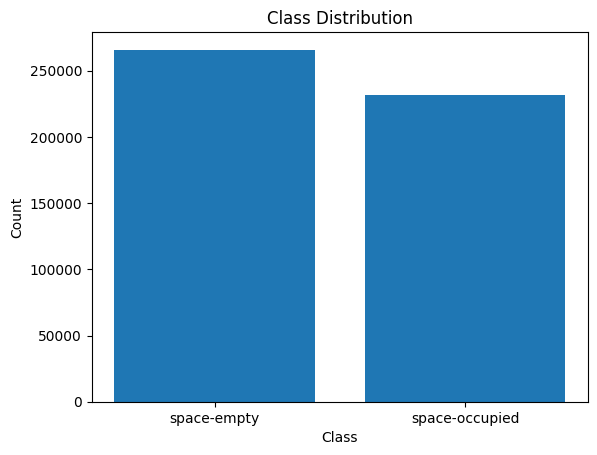

In [4]:
annotations = pd.read_csv('train/_annotations.csv')
counts = annotations['class'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

The distribution of the dataset between the space-empty and space-occupied classes is normal. It is not skewed to one class which helps the models learning and decreases the chances of overfitting. Overfitting is the concept of a model learning on a specific class more than others cause the frequency of the class is significantly higher than other class.

In [5]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497856 entries, 0 to 497855
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  497856 non-null  object
 1   width     497856 non-null  int64 
 2   height    497856 non-null  int64 
 3   class     497856 non-null  object
 4   xmin      497856 non-null  int64 
 5   ymin      497856 non-null  int64 
 6   xmax      497856 non-null  int64 
 7   ymax      497856 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 30.4+ MB


The info method shows the metrics of the dataframe. The dataset has 497856 rows and 8 columns. The following are the columns available:
* filename - name of the file
* width - width of the image file pixels
* height - height of the image file pixels
* class - class that the file belongs to
* xmin - bounding box x1 coordinate
* ymin - bounding box y1 coordinate
* xmax - bounding box x2 coordinate
* ymax - bounding box y2 coordinate

The filename and class columns are the ones which have values of type object. All other columns have integer values

## Preprocessing

In [9]:
# Set the path to the PKLot dataset directory

data_dir = ""
# Set the path to the directory where you want to save the preprocessed images
preprocessed_dir = 'preprocessed/'

# Create the directory if it doesn't exist
if not os.path.exists(preprocessed_dir):
    os.makedirs(preprocessed_dir)

# Set the desired image size
img_size = (224, 224)

# Loop through each image in the train, valid, and test folders
for folder in ['train', 'valid', 'test']:
    if not os.path.exists(preprocessed_dir+folder+"/"):
        os.makedirs(preprocessed_dir+folder+"/")
    folder_path = os.path.join(data_dir, folder)
    annotations_path = os.path.join(folder_path, '_annotations.csv')
    annotations_df = pd.read_csv(annotations_path)

    for index, row in annotations_df.iterrows():
        # Load the image
        img_path = os.path.join(folder_path, row['filename'])
        img = cv2.imread(img_path)

        # Extract the bounding box coordinates
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']

        # Crop the image to the bounding box
        cropped_img = img[ymin:ymax, xmin:xmax]

        # Resize the image
        resized_img = cv2.resize(cropped_img, img_size)

        # Convert the image to grayscale
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

        # Save the preprocessed image to the preprocessed directory
        if not os.path.exists(os.path.join(preprocessed_dir,folder,row['class'])):
            os.makedirs(os.path.join(preprocessed_dir,folder,row['class']))
        preprocessed_img_path = os.path.join(preprocessed_dir,folder,row['class'], row['filename'])
        cv2.imwrite(preprocessed_img_path, gray_img)

The preprocess function is used to take each image from all three folders train, valid and test. After reading the images, the files are cropped to center the parking space so the image processing model can process the parking space only and ignore the objects and pixels besides it. The files are then converted to greyscale and stored into the following folder format:

* train --
    * space-empty -- images
    * space-occupied -- images

* valid --
    * space-empty -- images
    * space-occupied -- images

* test --
    * space-empty -- images
    * space-occupied -- images

## Modeling

In [17]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'preprocessed/train',
    target_size=(224, 224),
    batch_size=32,
    classes=['space-empty', 'space-occupied'],
    class_mode='binary'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    'preprocessed/valid',
    target_size=(224, 224),
    batch_size=32,
    classes=['space-empty', 'space-occupied'],
    class_mode='binary'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'preprocessed/test',
    target_size=(224, 224),
    batch_size=32,
    classes=['space-empty', 'space-occupied'],
    class_mode='binary'
)

# Define the convolutional neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

Found 14125 images belonging to 2 classes.
Found 4029 images belonging to 2 classes.
Found 2032 images belonging to 2 classes.
Epoch 1/10
442/442 [==============================] - 490s 1s/step - loss: 0.1828 - accuracy: 0.9267 - val_loss: 0.0670 - val_accuracy: 0.9779
Epoch 2/10
442/442 [==============================] - 456s 1s/step - loss: 0.0720 - accuracy: 0.9769 - val_loss: 0.0493 - val_accuracy: 0.9831
Epoch 3/10
442/442 [==============================] - 481s 1s/step - loss: 0.0525 - accuracy: 0.9832 - val_loss: 0.0400 - val_accuracy: 0.9859
Epoch 4/10
442/442 [==============================] - 581s 1s/step - loss: 0.0388 - accuracy: 0.9879 - val_loss: 0.0257 - val_accuracy: 0.9921
Epoch 5/10
442/442 [==============================] - 547s 1s/step - loss: 0.0362 - accuracy: 0.9887 - val_loss: 0.0281 - val_accuracy: 0.9906
Epoch 6/10
442/442 [==============================] - 530s 1s/step - loss: 0.0244 - accuracy: 0.9934 - val_loss: 0.0238 - val_accuracy: 0.9933
Epoch 7/10
442/

Finally, the files are read from the specific folders using ImageGenerators. A Convolutional 2D model is created to process the image files. The following are the layers in the Convolutional 2D model:
* Conv2D layer - relu - 32
* Maxpool layer
* Conv2D layer - relu - 32
* Maxpool layer
* Conv2D layer - relu - 64
* Maxpool layer
* Flatten layer
* Dense layer - Relu - 128
* Dropout layer
* Dense layer - Sigmoid

The loss function used is binary-crossentropy and the metric accuracy is calculated across 10 epochs. The acquired loss at the end of the model fitting is 4% and the accuracy of the model is 98.9%